In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from astropy.time import Time
from astropy.coordinates import get_sun
import os
from tqdm import tqdm
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
from functions import mask_zone


In [16]:
## PARAMETERS ##

ra_grid = np.linspace(0, 360, int(360/1))
dec_grid = np.linspace(-90, 90, int(180/1))
dec_mesh, ra_mesh = np.meshgrid(dec_grid, ra_grid)
ra_grid_rad = np.radians(ra_grid)
dec_grid_rad = np.radians(dec_grid)
dec_mesh_rad, ra_mesh_rad = np.meshgrid(dec_grid_rad, ra_grid_rad)
Gmag = 6
current_year = datetime.now().year
current_month = datetime.now().month
current_day = datetime.now().day
files_version = '0005'
processing_folder = '../processing_files'
sun_exclusion_angle = 117

# # SUN_ANGLE array
start_date = Time(datetime(current_year,1,1), scale='utc').jd + 0.5 # Midday
end_date = Time(datetime(current_year,12,31), scale='utc').jd + 0.5 # Midday
dates = np.arange(start_date, end_date, 1)
time_array = Time(dates, format='jd', scale='utc').jd
# # Get the sun position at these times
# sun_angle_grid = get_sun(Time(time_array, format='jd', scale='utc')).ra.value

In [17]:
ra_results = np.array([])
dec_results = np.array([])
eff_max_results = np.array([])
eff_med_results = np.array([])

with open(os.path.join(processing_folder, 'time_eff_interpolated_table_Gmag' + str(Gmag) + '_' + str(current_year) + '_V' + files_version), 'rb') as file:
    interp_data = pd.read_pickle(file)
    
# Mask visibility cone
columns = ['date', 'interp_values']
masked_interp_data = pd.DataFrame(columns=columns)

# Mask sun Exclusion angle
for day, efficiency_day in zip(time_array,interp_data['interp_values'].values):
    EFF = efficiency_day.reshape(len(ra_grid), len(dec_grid))
    # apply sun exclusion angle
    EFF = mask_zone(ra_mesh, dec_mesh, EFF, cone_center = 'sun', start_zone = sun_exclusion_angle, end_zone = 180, day = day, single_target = False)
    temp_df = pd.DataFrame([[day, EFF]], columns=columns)
    masked_interp_data = pd.concat([masked_interp_data, temp_df], ignore_index=True) 

#stack data
data_3d = np.stack(masked_interp_data['interp_values'].values)  

# Convert nans to 0
data_3d = np.nan_to_num(data_3d, nan=0)
        

In [18]:
# Iterate over RA/DEC combinations
for i in tqdm(range(360)):
    for j in range(180):
        
        target_eff = data_3d[:, i, j]
        
        RA_target = ra_mesh_rad[i, j]
        Dec_target = dec_mesh_rad[i, j]
        
        #print(RA_target,Dec_target)
        #for k,day in enumerate(time_array):
        #   target_eff[k] = mask_zone(RA_target, Dec_target, target_eff[k], cone_center = 'sun', start_zone = 120, end_zone = 180, day = day, single_target = True)
                
        valid_efficiencies = target_eff[target_eff != 0]            

        # If there are valid efficiencies left, compute max and median
        if valid_efficiencies.size > 0:
            eff_max = np.max(valid_efficiencies)/100  # Max of valid efficiencies
            eff_med = np.median(valid_efficiencies)/100  # Median of valid efficiencies
        else:
            eff_max = 0  # If no valid efficiencies, set to 0
            eff_med = 0  # If no valid efficiencies, set to 0
        
        # Store the results
        ra_results = np.append(ra_results,RA_target)
        dec_results = np.append(dec_results,Dec_target)
        eff_max_results = np.append(eff_max_results,eff_max)
        eff_med_results = np.append(eff_med_results,eff_med)

100%|██████████| 360/360 [00:02<00:00, 137.32it/s]


In [19]:

filename = f"etc_visibility_js_Gmag{Gmag}_updated_{current_day}_{current_month}_SEA_{sun_exclusion_angle}.txt"

# Open the text file for writing
with open(filename, "w") as file:
    
    # Write the header
    file.write("/** \n")
    file.write(" *  @file    The visibility table for the ETC implementation. \n")
    file.write(" *           Derived from the CHEOPS Transit SNR Predictor spread sheet GO v1.13 \n")
    file.write(" *  @author  Lendl Monika  (MLE)  <monika.lendl@oeaw.ac.at> \n")
    file.write(" *  @author  Ottacher Harald  (HOT)  <harald.ottacher@oeaw.ac.at> \n")
    file.write(" *  @author  Heitzmann Alexis  (AHE)  <alexis.heitzmann@unige.ch> \n")
    file.write(" *  @version 2.0 \n")
    file.write(" *  @copyright IWF, last update: 30.01.2025 \n")
    file.write(" */ \n")
    file.write("/** \n")
    file.write(" *  @constant {Array.<EfficencyEntry>} Visibility \n")
    file.write(" *  The visibility information contains the efficiency calculated for noise limits \n")
    file.write(" *  from scattered light for different right ascensions and declinations. \n")
    file.write(" */  \n")
    file.write("// -- Visibility Table -- \n")
    file.write("const Visibility = [\n")
    # Loop through the values and write the formatted data to the file
    for idx, (ra, dec, eff_max, eff_med) in enumerate(zip(ra_results, dec_results, eff_max_results, eff_med_results)):
        if idx == (len(ra_results)-1):
            file.write(f"   {{ RA:{ra:7.5f}, DEC:{dec:8.5f}, EFF_MAX:{eff_max:4.3f} ,EFF_MED:{eff_med:4.3f}}}\n")
            file.write("]")
        else:
            file.write(f"   {{ RA:{ra:7.5f}, DEC:{dec:8.5f}, EFF_MAX:{eff_max:4.3f} ,EFF_MED:{eff_med:4.3f}}},\n")



# PLOTS

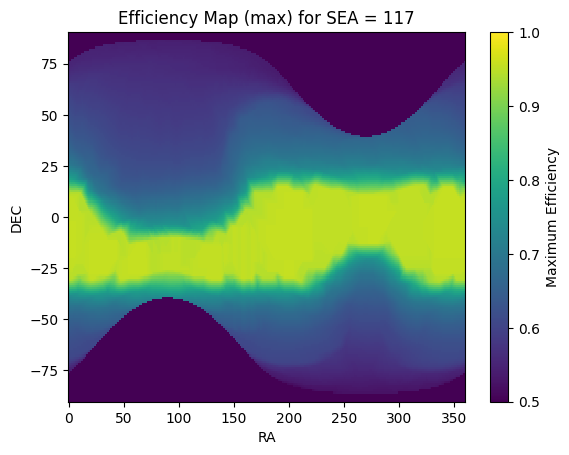

In [20]:

ra_grid = np.linspace(0, 360, int(360/1))
dec_grid = np.linspace(-90, 90, int(180/1))
eff_med_grid = eff_med_results.reshape(360, 180).T
eff_max_grid = eff_max_results.reshape(360, 180).T

# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Use imshow to display the efficiency grid with a color map
cax = ax.pcolormesh(ra_grid, dec_grid, eff_max_grid, cmap='viridis', vmin = 0.5, vmax = 1, shading='auto')

# Add color bar to the plot
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Maximum Efficiency')

# Show plot
plt.title(f'Efficiency Map (max) for SEA = {sun_exclusion_angle}')
plt.xlabel('RA')
plt.ylabel('DEC')

plt.savefig(f'max_eff_Gmag{Gmag}_updated_{current_day}_{current_month}_SEA_{sun_exclusion_angle}.png', format = 'png')

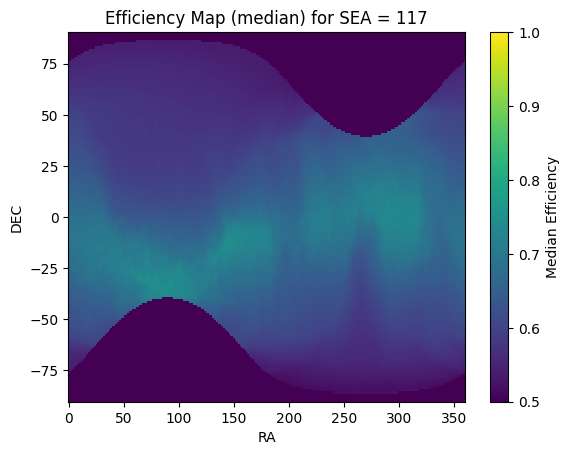

In [21]:
# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Use imshow to display the efficiency grid with a color map
cax = ax.pcolormesh(ra_grid, dec_grid, eff_med_grid, cmap='viridis', vmin = 0.5, vmax = 1,shading='auto')

# Add color bar to the plot
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Median Efficiency')

# Show plot
plt.title(f'Efficiency Map (median) for SEA = {sun_exclusion_angle}')
plt.xlabel('RA')
plt.ylabel('DEC')

plt.savefig(f'med_eff_Gmag{Gmag}_updated_{current_day}_{current_month}_SEA_{sun_exclusion_angle}.png', format = 'png')